In [1]:
using DifferentialEquations
using Plots
include("src/Utils.jl");
using Optim
using Plots.PlotMeasures

## The Tsai model

As reported in the Tsai et al. 2008 paper, a symmetric version is

$$
\frac{d}{dt}p_i = \alpha(p_{tot} - p_i) - \left(\alpha_0 + \frac{p_{i - 1}^n}{1 + p_{i - 1}^n}\right)p_i
$$

If we re-group the parameters

$$
\frac{d}{dt}p_i = \alpha p_{tot} - (\alpha + \alpha_0)p_i - \frac{p_{i - 1}^n}{1 + p_{i - 1}^n}p_i
$$

Let $B = \alpha + \alpha_0$ and $A = \alpha p_{tot}$. The strength of leaky regulation is simply the first-order degradation rate ($B$) with a baseline

$$
\frac{d}{dt}p_i = A - \left(B + \frac{p_{i - 1}^n}{1 + p_{i - 1}^n}\right) p_i
$$

This contrasts the repressilator model where leaky expression pops up as a zeroth-order production term

If the equilibrium is hyperbolic, it is stable if and only if

$$
-2B(1 + p_*^n)^2 + (n - 2 - 2p_*^n)p_*^n <0
$$

Where $(p_*, p_*, p_*)$ is an equilibrium. Time unit is $1/\beta$, where $\beta$ the strength of negative regulation, and the unit of concentration is $K_M$

In [2]:
function tsai!(dX, X, p, t)
    p1, p2, p3 = X
    A, B, n = p
    
    dX[1] = A - (B + p3^n/(1 + p3^n))*p1
    dX[2] = A - (B + p1^n/(1 + p1^n))*p2
    dX[3] = A - (B + p2^n/(1 + p2^n))*p3
    
    nothing
end;

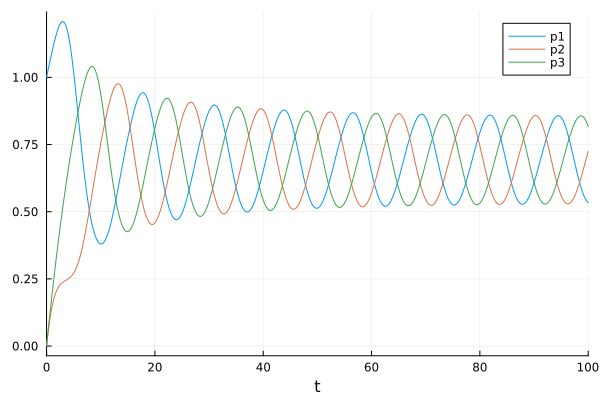

In [3]:
A = 0.2
B = 0.1
n = 4

p0 = [1, 0, 0]
tspan = (0, 100)

prob = ODEProblem(tsai!, p0, tspan, [A, B, n])
sol = solve(prob, abstol=1e-8, reltol=1e-8)

plot(sol, labels=reshape(["p1", "p2", "p3"], 1, :))

## Find equalibrium

In [5]:
symmetric_rhs(p, A, B, n) = A - (B + p^n/(1 + p^n))*p

A = 0.2
B = 0.1
n = 4

res = optimize(x -> symmetric_rhs(x, A, B, n)^2, 0.0, 10.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 10.000000]
 * Minimizer: 6.939154e-01
 * Minimum: 5.240618e-18
 * Iterations: 16
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 17

In [6]:
hopf_ev(pss, A, B, n) = -2*B*(1 + pss^n)^2 + (n - 2 - 2*pss^n)*pss^n

hopf_ev (generic function with 1 method)

## Find Hopf points

In [7]:
A = 0.2
B = 0.1
n = 4

function hopf_ev_from_para(_A, _B, _n)
    res = optimize(x -> symmetric_rhs(x, _A, _B, _n)^2, 0.0, 20.0)
    pss = first(Optim.minimizer(res))
    return hopf_ev(pss, _A, _B, _n)
end

res = optimize(x -> hopf_ev_from_para(A, x, n)^2, 0.0, 10.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 10.000000]
 * Minimizer: 1.147210e-01
 * Minimum: 4.635765e-20
 * Iterations: 17
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 18

In [8]:
hopf_ev_from_para(0.2, 0.17, 4)

-0.184928375982638

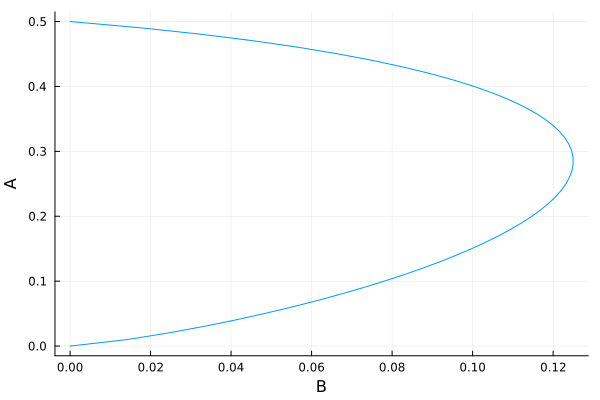

In [8]:
A_vec = 0:0.01:0.5
hopf_B_vec = zeros(length(A_vec))
n = 4

for (i, A) in enumerate(A_vec)
    res = optimize(x -> hopf_ev_from_para(A, x, n)^2, 0.0, 1.0)
    hopf_B_vec[i] = Optim.minimizer(res)
end

plot(hopf_B_vec, A_vec, legend=false)
xlabel!("B")
ylabel!("A")

## Numerically find the period

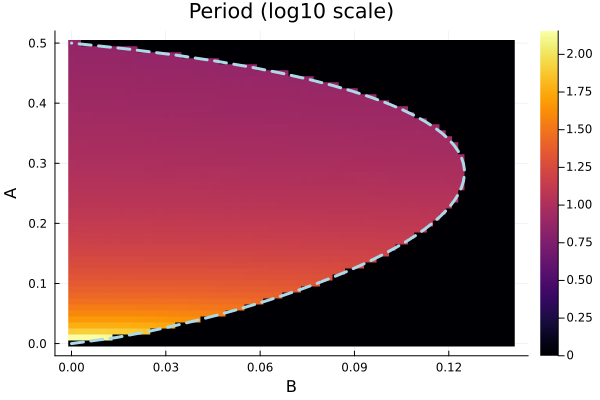

In [9]:
A_vec = 0:0.01:0.5
B_vec = 0:0.002:0.14
n = 4

# find period numerically
per_mat = zeros(length(B_vec), length(A_vec))
    
p0 = [1, 0, 0]

for (i, B) in enumerate(B_vec)
    for (j, A) in enumerate(A_vec)
        converge, amplitude, per, phase = 
        attracted_to(tsai!, p0, 50, [A, B, n], burnin=25, conv_tol=2e-3, amp_cutoff=2e-2)
        per_mat[i, j] = per
    end
end

hopf_B_vec = zeros(length(A_vec))

# find Hopf point from closed form
for (i, A) in enumerate(A_vec)
    res = optimize(x -> hopf_ev_from_para(A, x, n)^2, 0.0, 0.5)
    hopf_B_vec[i] = Optim.minimizer(res)
end
       
heatmap(B_vec, A_vec, (x -> x == -1 ? 0 : log(x)/log(10)).(transpose(per_mat)))
plot!(hopf_B_vec, A_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("B")
ylabel!("A")
title!("Period (log10 scale)")


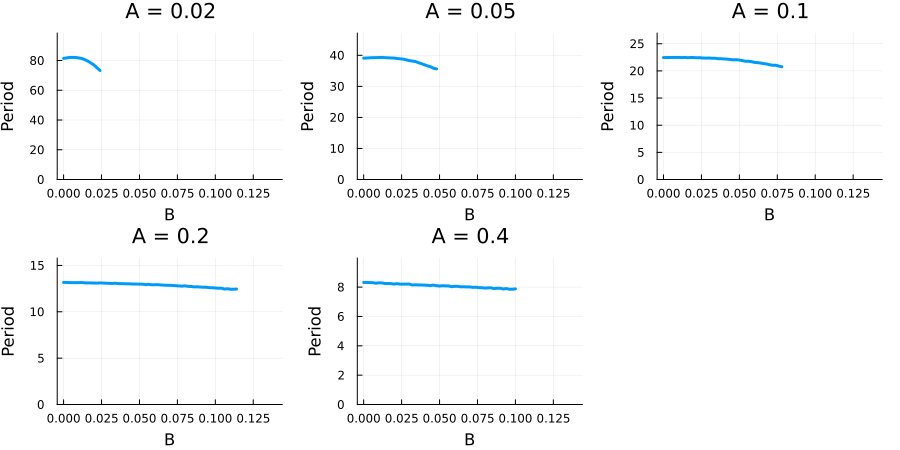

In [10]:
# intersect at fixed alpha
fixed_A_vec = [0.02, 0.05, 0.1, 0.2, 0.4]

fil_id = []
j = 1
for (i, A) in enumerate(A_vec)
    if abs(fixed_A_vec[j] - A) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_A_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

# plot
plot(B_vec, fil_per_mat; layout=5, legend=false, 
    title=(x -> "A = $x").(transpose(fixed_A_vec)), size=(900, 450), linewidth=3, margin=2.5mm)
# ylims!(0, 12)
xlabel!("B")
ylabel!("Period")
for i in range(1, 5)
    ylims!(0, maximum((x -> isnan(x) ? -1 : x).(fil_per_mat[:, i]))*1.2, subplot=i)
end
plot!()

## Try a different secondary param

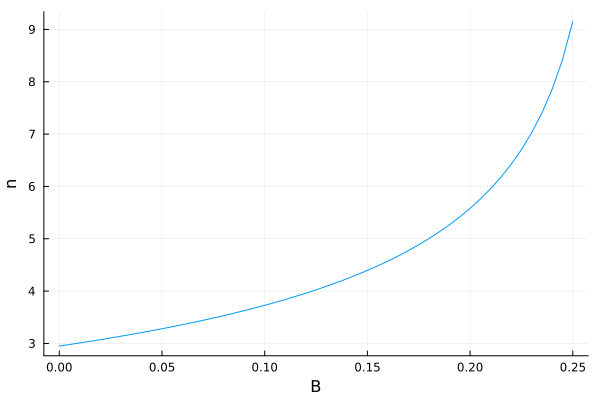

In [11]:
B_vec = 0:0.005:0.25
hopf_n_vec = zeros(length(B_vec))
A = 0.25

for (i, B) in enumerate(B_vec)
    res = optimize(x -> hopf_ev_from_para(A, B, x)^2, 2.0, 10.0)
    hopf_n_vec[i] = Optim.minimizer(res)
end

plot(B_vec, hopf_n_vec, legend=false)
xlabel!("B")
ylabel!("n")

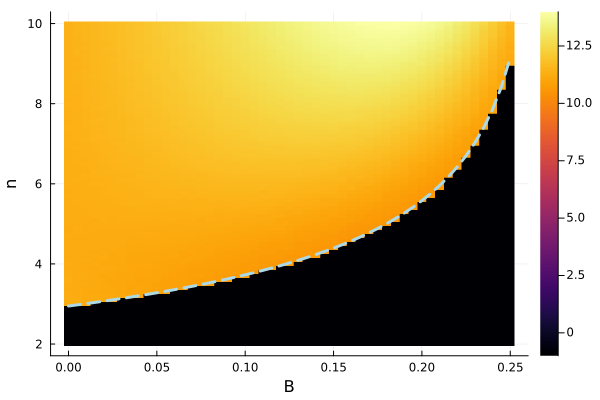

In [12]:
B_vec = 0:0.005:0.25
A = 0.25
n_vec = 2:0.1:10

# find period numerically
per_mat = zeros(length(B_vec), length(n_vec))
    
p0 = [1, 0, 0]

for (i, B) in enumerate(B_vec)
    for (j, n) in enumerate(n_vec)
        converge, amplitude, per, phase = 
        attracted_to(tsai!, p0, 50, [A, B, n], burnin=25, conv_tol=1e-2, amp_cutoff=2e-2)
        per_mat[i, j] = per
    end
end

hopf_n_vec = zeros(length(B_vec))

# find Hopf point from closed form
for (i, B) in enumerate(B_vec)
    res = optimize(x -> hopf_ev_from_para(A, B, x)^2, 0.0, 10.0)
    hopf_n_vec[i] = Optim.minimizer(res)
end
       
heatmap(B_vec, n_vec, transpose(per_mat))
plot!(B_vec, hopf_n_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("B")
ylabel!("n")


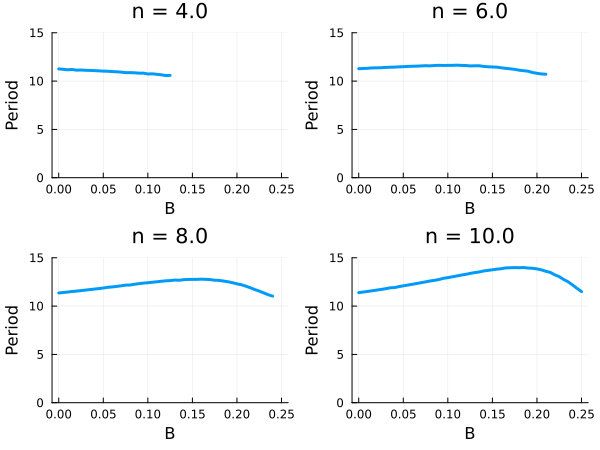

In [13]:
# intersect at fixed alpha
fixed_n_vec = [4.0, 6.0, 8.0, 10.0]

fil_id = []
j = 1
for (i, n) in enumerate(n_vec)
    if abs(fixed_n_vec[j] - n) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_n_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

# plot
plot(B_vec, fil_per_mat; layout=4, legend=false, 
    title=(x -> "n = $x").(transpose(fixed_n_vec)), size=(600, 450), linewidth=3)
ylims!(0, 15)
xlabel!("B")
ylabel!("Period")